# Gemma cup detection V2

## Import

In [9]:
import os
import glob
import sys
from datetime import datetime

import pandas as pd
import numpy as np
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from engine import train_one_epoch, evaluate
import transforms as T

from skimage import io, transform
from skimage.color import rgb2gray

import ipywidgets as widgets
from IPython.display import Image as IpImage
from IPython.display import display
from ipywidgets import Button, HBox, VBox
from PIL import Image as PilImage

from loaders import (
    GemmaDataset, 
    get_train_transform, 
    get_valid_transform, 
    Averager, 
    format_prediction_string, 
    show_predictions,
    predict_loader,
)

## Define Constants

In [2]:
data_path = os.path.join("..", "data_in")
images_path =os.path.join(data_path, "images")

test_index = 1

## Datasets

### Tests

#### Build test dataset

In [4]:
ds = GemmaDataset(
    csv=pd.read_csv(os.path.join(data_path, "boxes_final.csv")),
    images_path=images_path,
)
len(ds)

3767

#### Test boxes

In [5]:
len(ds.load_boxes(0))

2

In [6]:
ds.load_boxes(test_index)

(11,
 array([[631.53399658, 605.43951416, 669.23931885, 642.22845459],
        [899.24151611, 891.42657471, 936.94677734, 926.57598877],
        [699.29949951, 552.85705566, 739.0223999 , 591.03417969],
        [804.58917236, 852.86560059, 884.03497314, 924.50311279],
        [588.1729126 , 806.08197021, 657.92767334, 871.56750488],
        [840.01861572, 959.42999268, 886.85852051, 993.87109375],
        [625.36279297, 900.19134521, 698.74938965, 967.69586182],
        [688.91815186, 620.81872559, 761.61076504, 695.78479004],
        [852.00082397, 652.19805908, 914.58917236, 728.26046753],
        [914.32354736, 613.45507812, 946.37310791, 653.81768799],
        [939.84625244, 695.87548828, 964.86911011, 724.15185547]]))

In [7]:
ds.load_boxes(test_index)[0:1]

(11,)

#### Test images

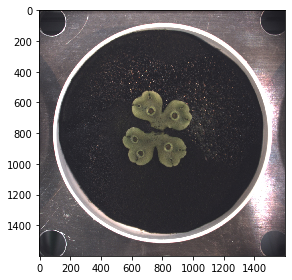

In [10]:
img = ds.load_image(test_index)
io.imshow(img) 
io.show()

#### Test sample

In [11]:
ds.get_by_sample_name("b0KXwBrE57rCtnxjL2jKk0AXGwCI.jpg")

(tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          [0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          [0.1725, 0.1725, 0.1725,  ..., 0.0941, 0.0941, 0.0941],
          ...,
          [0.2627, 0.2745, 0.2863,  ..., 0.1137, 0.1137, 0.1137],
          [0.2627, 0.2627, 0.2706,  ..., 0.1137, 0.1137, 0.1137],
          [0.2549, 0.2627, 0.2588,  ..., 0.1137, 0.1137, 0.1137]],
 
         [[0.1608, 0.1608, 0.1608,  ..., 0.0941, 0.0941, 0.0941],
          [0.1608, 0.1608, 0.1608,  ..., 0.0941, 0.0941, 0.0941],
          [0.1647, 0.1647, 0.1647,  ..., 0.0941, 0.0941, 0.0941],
          ...,
          [0.2549, 0.2667, 0.2784,  ..., 0.1059, 0.1059, 0.1059],
          [0.2431, 0.2549, 0.2627,  ..., 0.1059, 0.1059, 0.1059],
          [0.2353, 0.2431, 0.2510,  ..., 0.1059, 0.1059, 0.1059]],
 
         [[0.1804, 0.1804, 0.1804,  ..., 0.1020, 0.1020, 0.1020],
          [0.1804, 0.1804, 0.1804,  ..., 0.1020, 0.1020, 0.1020],
          [0.1843, 0.1843, 0.1843,  ...,

In [12]:
dd_sample = widgets.Dropdown(options=sorted(ds.images))

image_output = widgets.Output(layout={"border": "1px solid black"})
rects_output = widgets.Output(layout={"border": "1px solid black"})


def print_final_rects(change):
    image_output.clear_output()
    rects_output.clear_output()
    
    image, targets, _ = ds.get_by_sample_name(change.new)
                             
    boxes = targets['boxes'].cpu().numpy().astype(np.int32)
    image = image.permute(1,2,0).cpu().numpy()

    with image_output:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        ax.set_axis_off()
        for box in boxes:
            ax.add_patch(
                patches.Rectangle(
                    (box[0], box[1]), 
                    box[2] - box[0], 
                    box[3] - box[1],
                    linewidth=2, 
                    edgecolor="r", 
                    facecolor="none",
                )
            )
        ax.imshow(image)
        plt.show()
    
    with rects_output:
        display(
            pd.DataFrame(
                [box for box in boxes], 
                columns=["x1", "y1", "x2", "y2"],                
            )
        )


dd_sample.observe(print_final_rects, names="value")
display(dd_sample, HBox([image_output, rects_output]))

Dropdown(options=('b-1HoJ-Hqz5STrwrZHGBYdjAE3Q.jpg', 'b-38OOnRNVd8OdKdmNYZXXy83E.jpg', 'b-3Q-HdqeuB2sRxMIzzUPN…

## Create model

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [19]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Build data loaders

### Create train and test dataframes

#### Load and clean dataframe

In [20]:
df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "boxes.csv"))
df = df[(df.width != 0) & (df.height != 0)].reset_index()
df.head()

,index,filename,x,y,width,height
0,0,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,690.798218,560.637146,45.351654,39.815979
1,1,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,1004.213104,791.837433,43.049530,46.096863
2,2,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,611.747009,738.196106,91.825195,84.914490
3,3,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,905.668762,749.575195,79.746094,84.656433
4,4,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,708.588226,613.453003,94.325226,72.136810


#### Split dataframe

In [21]:
sizes: tuple = (0.8, 0.20)
dataset_size = len(list(df.filename.unique()))
indices = [ i for i in list(df.filename.unique())]

split_train = int(np.floor(sizes[0] * dataset_size))
split_test = int(np.floor(sizes[1] * dataset_size)) + split_train

np.random.shuffle(indices)
train_indices, test_indices = (
    indices[:split_train],
    indices[split_train:split_test],
)

df_train = df[df.filename.isin(train_indices)]
df_test = df[df.filename.isin(test_indices)]

In [22]:
df_train.drop_duplicates(subset=["filename"]).head()

,index,filename,x,y,width,height
0,0,b00mXpDa2KjZ1b8xWs1aq7vRVvI.jpg,690.798218,560.637146,45.351654,39.815979
14,14,b0BBwUoWkQfXpAUn8gvPh0AJy1hQ.jpg,NaN,NaN,NaN,NaN
15,15,b0DaRvfMv4Ve9fQ7-vmzY5lXanY.jpg,NaN,NaN,NaN,NaN
16,16,b0Dkf149PgiY8uzDB1naeNyC0L9A.jpg,869.565491,847.176147,80.138489,65.199829
22,22,b0K9go-7zp6ItpVeN-bmIwAgU12Y.jpg,NaN,NaN,NaN,NaN


In [23]:
df_test.drop_duplicates(subset=["filename"]).head()

,index,filename,x,y,width,height
10,10,b00s9swai4uy9RmDXcnkiY1PpZ2M.jpg,610.178619,555.672180,52.402435,47.337433
20,20,b0F36HFy2D01M3WdyopeVzzKaP4.jpg,NaN,NaN,NaN,NaN
21,21,b0G-uQyqygMNBuOC3sBij5u5NruI.jpg,921.026611,686.049683,43.314270,31.259033
33,33,b0Kn3PC0uM7Bezjtf3JSNN4utEFQ.jpg,NaN,NaN,NaN,NaN
88,88,b0QW0SprPZiHjZybnVj2TRmix-0.jpg,NaN,NaN,NaN,NaN


#### Look for leakage

In [24]:
# Look for leakage
pd.merge(
    df_train,
    df_test,
    on=list(df_test.columns),
    how="inner",
).head()

,index,filename,x,y,width,height


#### Ensure images are only in one set

In [25]:
set(df_train.filename.to_list()).intersection(set(df_test.filename.to_list()))

set()

### Build datasets

In [26]:
train_dataset = GemmaDataset(
    csv=df_train, 
    transform=get_train_transform(),
    images_path=images_path,
)
valid_dataset = GemmaDataset(
    csv=df_test,
    transform=get_valid_transform(),
    images_path=images_path,
)

In [27]:
for i in range(len(train_dataset)):
    train_dataset[i]

### Build loaders

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 1

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

## Select device

In [29]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

## Sample

In [30]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [31]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
boxes

array([[ 690,  560,  736,  600],
       [1004,  791, 1047,  837],
       [ 611,  738,  703,  823],
       [ 905,  749,  985,  834],
       [ 708,  613,  802,  685],
       [ 886,  571,  941,  620],
       [ 960,  604, 1015,  664],
       [ 967,  839, 1015,  882],
       [ 761,  551,  801,  581],
       [ 869,  632,  952,  711]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


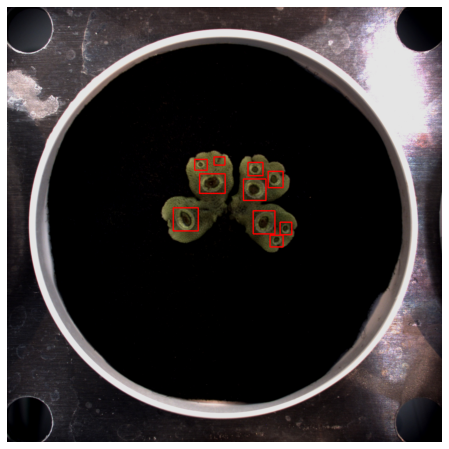

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(
        sample,
        (box[0], box[1]),
        (box[2], box[3]),
        (220, 0, 0), 
        3
    )

ax.set_axis_off()
ax.imshow(sample)

## Train

In [33]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [34]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #10 loss: 0.1266752928495407
Iteration #20 loss: 0.007661217357963324
Iteration #30 loss: 0.34658054419495915
Iteration #40 loss: 0.6548683932349939
Epoch #0 loss: 0.5865594437262007
Iteration #50 loss: 0.042661018669605255
Iteration #60 loss: 0.011892292648553848
Iteration #70 loss: 0.1899934583278615
Iteration #80 loss: 0.4951445589989474
Epoch #1 loss: 0.37744130285169764


## Predict

In [35]:
images, targets, image_ids = next(iter(valid_data_loader))
images, targets, image_ids

((tensor([[[0.1882, 0.1961, 0.1922,  ..., 0.1176, 0.1176, 0.1098],
           [0.1961, 0.2000, 0.1961,  ..., 0.1137, 0.1137, 0.1098],
           [0.1922, 0.1961, 0.1961,  ..., 0.1137, 0.1137, 0.1137],
           ...,
           [0.2000, 0.2039, 0.2000,  ..., 0.1255, 0.1216, 0.1216],
           [0.1922, 0.1961, 0.2000,  ..., 0.1255, 0.1216, 0.1216],
           [0.1804, 0.1922, 0.1961,  ..., 0.1255, 0.1216, 0.1216]],
  
          [[0.1686, 0.1765, 0.1843,  ..., 0.1137, 0.1137, 0.1059],
           [0.1765, 0.1804, 0.1882,  ..., 0.1098, 0.1098, 0.1059],
           [0.1843, 0.1882, 0.1882,  ..., 0.1098, 0.1098, 0.1098],
           ...,
           [0.1922, 0.1961, 0.2000,  ..., 0.1216, 0.1176, 0.1176],
           [0.1843, 0.1882, 0.2000,  ..., 0.1216, 0.1176, 0.1176],
           [0.1725, 0.1843, 0.1961,  ..., 0.1216, 0.1176, 0.1176]],
  
          [[0.1843, 0.1922, 0.1961,  ..., 0.1333, 0.1333, 0.1255],
           [0.1922, 0.1961, 0.2000,  ..., 0.1294, 0.1294, 0.1255],
           [0.1961, 0.

In [36]:
results = predict_loader(
    model=model,
    loader=valid_data_loader,
    device=device,
    detection_threshold=0.5,
)

In [37]:
results[0]

{'image_id': 0,
 'PredictionString': '0.9607 609 556 659 599 0.9358 686 536 740 580 0.9205 843 597 907 657 0.9128 565 767 634 842 0.7796 550 845 587 879 0.7612 512 794 565 826',
 'scores': array([0.96067166, 0.9358418 , 0.92049116, 0.9127931 , 0.7796074 ,
        0.7611753 ], dtype=float32),
 'boxes': array([[609, 556, 659, 599],
        [686, 536, 740, 580],
        [843, 597, 907, 657],
        [565, 767, 634, 842],
        [550, 845, 587, 879],
        [512, 794, 565, 826]])}

In [38]:
test_df = pd.DataFrame(list(results.values()), columns=['image_id', 'PredictionString', "scores", "boxes"])
test_df.head()

,image_id,PredictionString,scores,boxes
0,0,0.9607 609 556 659 599 0.9358 686 536 740 580 ...,"[0.96067166, 0.9358418, 0.92049116, 0.9127931,...","[[609, 556, 659, 599], [686, 536, 740, 580], [..."
1,1,0.6219 716 838 754 875 0.5782 719 759 782 822,"[0.621871, 0.57819635]","[[716, 838, 754, 875], [719, 759, 782, 822]]"
2,2,0.6776 655 866 689 904 0.5976 892 703 931 741 ...,"[0.6775613, 0.59757817, 0.5569195]","[[655, 866, 689, 904], [892, 703, 931, 741], [..."
3,3,,[],[]
4,4,,[],[]


In [39]:
iter_loader = iter(valid_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


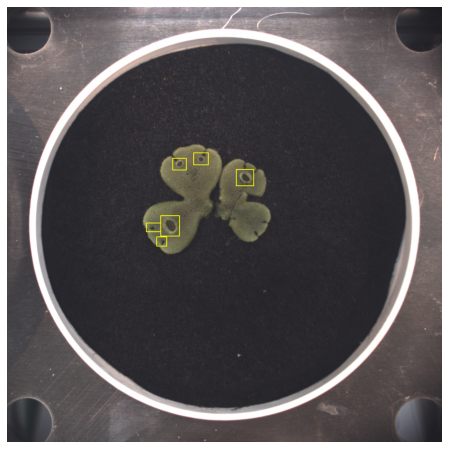

In [40]:
show_predictions(*next(iter_loader), device, results)

## Save state dict

In [41]:
state_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "state_dict.pth")

In [42]:
torch.save(
    model.state_dict(), 
    state_output_path
)

## Save model

In [43]:
model_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "model.pth")

In [44]:
torch.save(model, model_output_path)

## Predict with stored data

### Load model

In [45]:
loaded_model = torch.load(os.path.join("..", "models", "default_model.pth"))

### Predict rectangles

In [46]:
predictions = predict_loader(
    model=loaded_model,
    loader=valid_data_loader,
    device=device,
    detection_threshold=0.5,
)

### View predictions

In [47]:
predict_loader = iter(valid_data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


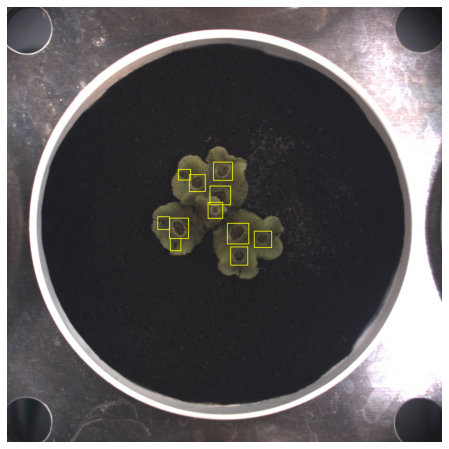

In [54]:
show_predictions(*next(predict_loader), device, predictions)